In [1]:
#hiddencell
import micropip
await micropip.install("seaborn")
# from pbl_tools import *

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

fe = fm.FontEntry(fname = 'MaruBuri-Regular.otf', name = 'MaruBuri')
fm.fontManager.ttflist.insert(0, fe)
plt.rc('font', family='MaruBuri')

# **대구 교통 사고 피해 예측 AI 경진대회 Baseline Code**

## **Fixed Random Seed**  

seed 값에 의해 동일한 코드를 사용해도 결과가 다를 수 있기에, 동일한 결과를 위해 seed 값을 고정시킵니다

In [2]:
import os
import random
import numpy as np

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42)

## **데이터 불러오기 및 상위행 확인**  

train.csv, test.csv 파일을 로드하여 상위행을 출력해 봅시다

In [149]:
import pandas as pd 

train_org = pd.read_csv('train.csv') 
test_org = pd.read_csv('test.csv')

display(train_org.head())
display(test_org.tail())

,ID,사고일시,요일,기상상태,시군구,도로형태,노면상태,사고유형,사고유형 - 세부분류,법규위반,...,가해운전자 상해정도,피해운전자 차종,피해운전자 성별,피해운전자 연령,피해운전자 상해정도,사망자수,중상자수,경상자수,부상자수,ECLO
0,ACCIDENT_00000,2019-01-01 00,화요일,맑음,대구광역시 중구 대신동,단일로 - 기타,건조,차대사람,길가장자리구역통행중,안전운전불이행,...,상해없음,보행자,여,70세,중상,0,1,0,0,5
1,ACCIDENT_00001,2019-01-01 00,화요일,흐림,대구광역시 달서구 감삼동,단일로 - 기타,건조,차대사람,보도통행중,기타,...,상해없음,보행자,남,61세,경상,0,0,1,0,3
2,ACCIDENT_00002,2019-01-01 01,화요일,맑음,대구광역시 수성구 두산동,단일로 - 기타,건조,차대사람,차도통행중,안전운전불이행,...,상해없음,보행자,남,38세,경상,0,0,1,0,3
3,ACCIDENT_00003,2019-01-01 02,화요일,맑음,대구광역시 북구 복현동,단일로 - 기타,건조,차대차,추돌,안전운전불이행,...,상해없음,승용,남,36세,중상,0,1,0,0,5
4,ACCIDENT_00004,2019-01-01 04,화요일,맑음,대구광역시 동구 신암동,단일로 - 기타,건조,차대차,추돌,안전운전불이행,...,상해없음,승용,남,52세,경상,0,0,1,0,3


,ID,사고일시,요일,기상상태,시군구,도로형태,노면상태,사고유형
10958,ACCIDENT_50567,2022-12-31 18,토요일,맑음,대구광역시 남구 대명동,단일로 - 터널,건조,차대차
10959,ACCIDENT_50568,2022-12-31 18,토요일,맑음,대구광역시 수성구 시지동,단일로 - 기타,건조,차대차
10960,ACCIDENT_50569,2022-12-31 20,토요일,맑음,대구광역시 수성구 연호동,단일로 - 기타,건조,차대차
10961,ACCIDENT_50570,2022-12-31 20,토요일,맑음,대구광역시 수성구 범물동,교차로 - 교차로부근,건조,차대차
10962,ACCIDENT_50571,2022-12-31 21,토요일,맑음,대구광역시 동구 효목동,교차로 - 교차로부근,건조,차대차


## **train, test 데이터 기간 확인하기**  

학습(train) 데이터의 기간과 예측 대상이 되는 test 데이터의 기간을 살펴 봅니다

In [150]:
display(f"train : {train_org.iloc[0]['사고일시']} ~ {train_org.iloc[-1]['사고일시']}")
display(f"test : {test_org.iloc[0]['사고일시']} ~ {test_org.iloc[-1]['사고일시']}")     

'train : 2019-01-01 00 ~ 2021-12-31 23'

'test : 2022-01-01 01 ~ 2022-12-31 21'

## **예측 대상 확인하기**

sample_submission.csv를 로드하여 출력 형식을 확인해 봄으로서, 
대회 페이지 규칙에 기술되어 있는, 예측 대상이 무엇인지 확인해 봅시다.

최종적으로 예측해야 하는 값은 'ECLO'(인명피해 심각도) 값입니다. 

그러나, train데이터 컬럼에 있는 '사망자수', '중상자수', '경상자수', '부상자수'를 각각 예측하여 ECLO 예측값을 구할 수도 있습니다. 즉, ECLO 값을 예측하는 단일 모델로 접근할 수도,  각각을 별도로 예측하는 모델로 접근할 수도 있습니다. 

<img src="https://drive.google.com/uc?id=19PvSqu8k04D3a-Bskcl-d-Xkckkn2Fvv">  

In [151]:
sample_submission = pd.read_csv("sample_submission.csv")
sample_submission.head()

,ID,ECLO
0,ACCIDENT_39609,0
1,ACCIDENT_39610,0
2,ACCIDENT_39611,0
3,ACCIDENT_39612,0
4,ACCIDENT_39613,0


## **데이터 전처리**  

현재 '사고일시', '시군구', '도로형태' 컬럼은 반복되는 패턴으로 여러 정보를 포함하고 있습니다
이런 반복되는 패턴을 일반화하면 pandas에서 제공하는 str.extract를 통해 한 번에 추출 가능합니다  

## **파생 변수 생성 1 : 날짜, 시간정보 생성**

'사고일시' 컬럼으로 부터 연도, 월, 일, 시간 정보 추출 및 변환 합니다

In [152]:
train_df = train_org.copy()
test_df = test_org.copy()

time_pattern = r'(\d{4})-(\d{1,2})-(\d{1,2}) (\d{1,2})' 

train_df[['연', '월', '일', '시간']] = train_org['사고일시'].str.extract(time_pattern)
train_df[['연', '월', '일', '시간']] = train_df[['연', '월', '일', '시간']].apply(pd.to_numeric) # 추출된 문자열을 수치화해줍니다 
train_df = train_df.drop(columns=['사고일시']) # 정보 추출이 완료된 '사고일시' 컬럼은 제거합니다 

# 해당 과정을 test_x에 대해서도 반복해줍니다 
test_df[['연', '월', '일', '시간']] = test_org['사고일시'].str.extract(time_pattern)
test_df[['연', '월', '일', '시간']] = test_df[['연', '월', '일', '시간']].apply(pd.to_numeric)
test_df = test_df.drop(columns=['사고일시'])

display(f"columns of train_df : {train_df.columns}")
display(f"columns of test_df : {test_df.columns}")

"columns of train_df : Index(['ID', '요일', '기상상태', '시군구', '도로형태', '노면상태', '사고유형', '사고유형 - 세부분류',\n       '법규위반', '가해운전자 차종', '가해운전자 성별', '가해운전자 연령', '가해운전자 상해정도', '피해운전자 차종',\n       '피해운전자 성별', '피해운전자 연령', '피해운전자 상해정도', '사망자수', '중상자수', '경상자수', '부상자수',\n       'ECLO', '연', '월', '일', '시간'],\n      dtype='object')"

"columns of test_df : Index(['ID', '요일', '기상상태', '시군구', '도로형태', '노면상태', '사고유형', '연', '월', '일', '시간'], dtype='object')"

## **파생 변수 생성 2 : 공간(위치) 정보 생성** 

'시군구' 컬럼으로부터 의미 있는 공산 정보를 추출 및 변환 합니다

In [153]:
location_pattern = r'(\S+) (\S+) (\S+)'

train_df[['도시', '구', '동']] = train_org['시군구'].str.extract(location_pattern)
train_df = train_df.drop(columns=['시군구'])

test_df[['도시', '구', '동']] = test_org['시군구'].str.extract(location_pattern)
test_df = test_df.drop(columns=['시군구'])

display(f"columns of train_df : {train_df.columns}")
display(f"columns of test_df : {test_df.columns}")

"columns of train_df : Index(['ID', '요일', '기상상태', '도로형태', '노면상태', '사고유형', '사고유형 - 세부분류', '법규위반',\n       '가해운전자 차종', '가해운전자 성별', '가해운전자 연령', '가해운전자 상해정도', '피해운전자 차종',\n       '피해운전자 성별', '피해운전자 연령', '피해운전자 상해정도', '사망자수', '중상자수', '경상자수', '부상자수',\n       'ECLO', '연', '월', '일', '시간', '도시', '구', '동'],\n      dtype='object')"

"columns of test_df : Index(['ID', '요일', '기상상태', '도로형태', '노면상태', '사고유형', '연', '월', '일', '시간', '도시',\n       '구', '동'],\n      dtype='object')"

## **파생 변수 추출 3 : 도로 형태 정보 추출**  

'도로형태' 컬럼은 '단일로 - 기타'와 같은 패턴으로 구성되어 있습니다. 이를 두종류의 독립된 정보로 보고 두개의 컬럼으로 분리하여 생성합니다.

In [154]:
road_pattern = r'(.+) - (.+)'

train_df[['도로형태1', '도로형태2']] = train_org['도로형태'].str.extract(road_pattern)
train_df = train_df.drop(columns=['도로형태'])

test_df[['도로형태1', '도로형태2']] = test_org['도로형태'].str.extract(road_pattern)
test_df = test_df.drop(columns=['도로형태'])

display(f"columns of train_df : {train_df.columns}")
display(f"columns of test_df : {test_df.columns}")

"columns of train_df : Index(['ID', '요일', '기상상태', '노면상태', '사고유형', '사고유형 - 세부분류', '법규위반', '가해운전자 차종',\n       '가해운전자 성별', '가해운전자 연령', '가해운전자 상해정도', '피해운전자 차종', '피해운전자 성별',\n       '피해운전자 연령', '피해운전자 상해정도', '사망자수', '중상자수', '경상자수', '부상자수', 'ECLO', '연',\n       '월', '일', '시간', '도시', '구', '동', '도로형태1', '도로형태2'],\n      dtype='object')"

"columns of test_df : Index(['ID', '요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '도시', '구', '동',\n       '도로형태1', '도로형태2'],\n      dtype='object')"

## **파생 변수 4**

In [155]:
light_df = pd.read_csv('./external_open/대구 보안등 정보.csv', encoding='cp949')[['설치개수', '소재지지번주소']]

location_pattern = r'(\S+) (\S+) (\S+) (\S+)'

light_df[['도시', '구', '동', '번지']] = light_df['소재지지번주소'].str.extract(location_pattern)
light_df = light_df.drop(columns=['소재지지번주소', '번지'])

light_df = light_df.groupby(['도시', '구', '동']).sum().reset_index()
light_df.reset_index(inplace=True, drop=True)

C:\Users\kuils\AppData\Local\Temp\ipykernel_12196\107416115.py:1: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  light_df = pd.read_csv('./external_open/대구 보안등 정보.csv', encoding='cp949')[['설치개수', '소재지지번주소']]


## **파생 변수 5**

In [156]:
child_area_df = pd.read_csv('./external_open/대구 어린이 보호 구역 정보.csv', encoding='cp949').drop_duplicates()[['소재지지번주소']]
child_area_df['cnt'] = 1

location_pattern = r'(\S+) (\S+) (\S+) (\S+)'

child_area_df[['도시', '구', '동', '번지']] = child_area_df['소재지지번주소'].str.extract(location_pattern)
child_area_df = child_area_df.drop(columns=['소재지지번주소', '번지'])

child_area_df = child_area_df.groupby(['도시', '구', '동']).sum().reset_index()
child_area_df.reset_index(inplace=True, drop=True)

## **파생 변수 6**

In [157]:
parking_df = pd.read_csv('./external_open/대구 주차장 정보.csv', encoding='cp949')[['소재지지번주소', '급지구분']]
parking_df = pd.get_dummies(parking_df, columns=['급지구분'])

location_pattern = r'(\S+) (\S+) (\S+) (\S+)'

parking_df[['도시', '구', '동', '번지']] = parking_df['소재지지번주소'].str.extract(location_pattern)
parking_df = parking_df.drop(columns=['소재지지번주소', '번지'])

parking_df = parking_df.groupby(['도시', '구', '동']).sum().reset_index()
parking_df.reset_index(inplace=True, drop=True)

train_df, test_df 와 데이터 합치기

In [158]:
# train_df와 test_df에, light_df와 child_area_df, parking_df를 merge하세요.
train_df = pd.merge(train_df, light_df, how='left', on=['도시', '구', '동'])
train_df = pd.merge(train_df, child_area_df, how='left', on=['도시', '구', '동'])
train_df = pd.merge(train_df, parking_df, how='left', on=['도시', '구', '동'])

test_df = pd.merge(test_df, light_df, how='left', on=['도시', '구', '동'])
test_df = pd.merge(test_df, child_area_df, how='left', on=['도시', '구', '동'])
test_df = pd.merge(test_df, parking_df, how='left', on=['도시', '구', '동'])

train_df.fillna(0, inplace=True)
test_df.fillna(0, inplace=True)

## **전처리 결과 확인**

지금까지 전처리한 결과를 확인해 봅시다 

In [159]:
display(train_df.head())
display(test_df.head())

,ID,요일,기상상태,노면상태,사고유형,사고유형 - 세부분류,법규위반,가해운전자 차종,가해운전자 성별,가해운전자 연령,...,도시,구,동,도로형태1,도로형태2,설치개수,cnt,급지구분_1,급지구분_2,급지구분_3
0,ACCIDENT_00000,화요일,맑음,건조,차대사람,길가장자리구역통행중,안전운전불이행,승용,여,51세,...,대구광역시,중구,대신동,단일로,기타,391.0,2.0,11.0,0.0,0.0
1,ACCIDENT_00001,화요일,흐림,건조,차대사람,보도통행중,기타,승용,남,39세,...,대구광역시,달서구,감삼동,단일로,기타,932.0,0.0,0.0,1.0,3.0
2,ACCIDENT_00002,화요일,맑음,건조,차대사람,차도통행중,안전운전불이행,승용,남,70세,...,대구광역시,수성구,두산동,단일로,기타,473.0,5.0,0.0,0.0,0.0
3,ACCIDENT_00003,화요일,맑음,건조,차대차,추돌,안전운전불이행,승용,남,49세,...,대구광역시,북구,복현동,단일로,기타,534.0,11.0,0.0,9.0,5.0
4,ACCIDENT_00004,화요일,맑음,건조,차대차,추돌,안전운전불이행,승용,남,30세,...,대구광역시,동구,신암동,단일로,기타,2057.0,0.0,0.0,1.0,0.0


,ID,요일,기상상태,노면상태,사고유형,연,월,일,시간,도시,구,동,도로형태1,도로형태2,설치개수,cnt,급지구분_1,급지구분_2,급지구분_3
0,ACCIDENT_39609,토요일,맑음,건조,차대사람,2022,1,1,1,대구광역시,수성구,상동,교차로,교차로안,700.0,5.0,0.0,0.0,0.0
1,ACCIDENT_39610,토요일,맑음,건조,차대사람,2022,1,1,1,대구광역시,수성구,지산동,단일로,기타,0.0,10.0,0.0,0.0,2.0
2,ACCIDENT_39611,토요일,맑음,건조,차대차,2022,1,1,4,대구광역시,수성구,수성동2가,교차로,교차로안,0.0,1.0,0.0,0.0,0.0
3,ACCIDENT_39612,토요일,맑음,건조,차대차,2022,1,1,4,대구광역시,수성구,신매동,단일로,기타,0.0,7.0,0.0,2.0,1.0
4,ACCIDENT_39613,토요일,맑음,건조,차대차,2022,1,1,6,대구광역시,달서구,감삼동,교차로,교차로안,932.0,0.0,0.0,1.0,3.0


## **train, test 데이터의 독립변수, 종속 변수 분리**

모델 추론 시점에서 획득할 수 있는 데이터는 학습 시점에서 활용할 수 있는 데이터와 다를 수 있습니다  
그렇기에 본 baseline에서는 test 시점에서만 활용할 수 있는 데이터들(test의 column들)만 사용하여 train 데이터를 구성했습니다 

train_df 중에서 test_x가 가진 column들만 추출하여 train_x(독립변수)를 구성하고, train_df 중에서 예측 목표인 EPDO를 추출하여 train_y(종속변수)를 구성합니다

In [161]:
train_df = train_df[['ID','기상상태', '노면상태', '사고유형', '도로형태1', '도로형태2','ECLO']]
test_df =   test_df[['ID','기상상태', '노면상태', '사고유형', '도로형태1', '도로형태2']]

In [171]:
test_x = test_df.drop(columns=['ID']).copy()
train_x = train_df[test_x.columns].copy()
train_y = train_df['ECLO'].copy()
display(train_x.head())

,기상상태,노면상태,사고유형,도로형태1,도로형태2
0,맑음,건조,차대사람,단일로,기타
1,흐림,건조,차대사람,단일로,기타
2,맑음,건조,차대사람,단일로,기타
3,맑음,건조,차대차,단일로,기타
4,맑음,건조,차대차,단일로,기타


In [167]:
data2 = pd.read_csv('./external_open/countrywide_accident.csv')
road_pattern = r'(.+) - (.+)'

data2[['도로형태1', '도로형태2']] = data2['도로형태'].str.extract(road_pattern)
data2 = data2.drop(columns=['도로형태'])

display(f"columns of train_df : {data2.columns}")
data=data2[['ID','기상상태', '노면상태', '사고유형', '도로형태1', '도로형태2','ECLO']]
display(data.head())

"columns of train_df : Index(['ID', '사고일시', '요일', '기상상태', '시군구', '노면상태', '사고유형', '사고유형 - 세부분류',\n       '법규위반', '가해운전자 차종', '가해운전자 성별', '가해운전자 연령', '가해운전자 상해정도', '피해운전자 차종',\n       '피해운전자 성별', '피해운전자 연령', '피해운전자 상해정도', '사망자수', '중상자수', '경상자수', '부상자수',\n       'ECLO', '도로형태1', '도로형태2'],\n      dtype='object')"

,ID,기상상태,노면상태,사고유형,도로형태1,도로형태2,ECLO
0,COUNTRYWIDE_ACCIDENT_000000,맑음,건조,차대사람,교차로,교차로횡단보도내,3
1,COUNTRYWIDE_ACCIDENT_000001,맑음,건조,차대차,교차로,교차로안,3
2,COUNTRYWIDE_ACCIDENT_000002,맑음,건조,차대차,교차로,교차로안,5
3,COUNTRYWIDE_ACCIDENT_000003,맑음,건조,차대사람,기타,기타,10
4,COUNTRYWIDE_ACCIDENT_000004,맑음,건조,차대차,교차로,교차로안,7


In [176]:
train_x_notDaegu = data[test_x.columns]
train_y_notDaegu  = data['ECLO'].copy()
train_x_countrywide = pd.concat([train_x,train_x_notDaegu])
train_y_countrywide = pd.concat([train_y,train_y_notDaegu])


## **범주형(Categorical) 변수, 수치형 변수로 변환하기**

모델 학습을 위해 train_x의 문자열 타입의 컬럼들을 추출하고, LabelEncoder를 활용하여 이 컬럼들을 모두 수치형 변수로 변환해 보겠습니다

In [177]:
from sklearn.preprocessing import LabelEncoder

categorical_features = list(train_x_countrywide.dtypes[train_x_countrywide.dtypes == "object"].index)
# 추출된 문자열 변수 확인
display(categorical_features)

for i in categorical_features:
    le = LabelEncoder()
    le=le.fit(train_x_countrywide[i]) 
    train_x_countrywide[i]=le.transform(train_x_countrywide[i])
    
    for case in np.unique(test_x[i]):
        if case not in le.classes_: 
            le.classes_ = np.append(le.classes_, case) 
    test_x[i]=le.transform(test_x[i])
    
display(train_x_countrywide.head())
display(test_x.head())

['기상상태', '노면상태', '사고유형', '도로형태1', '도로형태2']

,기상상태,노면상태,사고유형,도로형태1,도로형태2
0,2,0,0,2,5
1,5,0,0,2,5
2,2,0,0,2,5
3,2,0,1,2,5
4,2,0,1,2,5


,기상상태,노면상태,사고유형,도로형태1,도로형태2
0,2,0,0,0,3
1,2,0,0,2,5
2,2,0,1,0,3
3,2,0,1,2,5
4,2,0,1,0,3


## **Model Train & Prediction** 

전체 학습 데이터에 대하여 학습후 최종 예측을 합니다. 여기서는 DecisionTreeRegressor 모델로 학습하고 예측하는 예시 코드입니다.

In [86]:
# test_x = test_x.drop(columns=['요일','도시','구','동','연','월','일','시간','설치개수','cnt','급지구분_1',	'급지구분_2',	'급지구분_3']).copy()
# train_x = train_x.drop(columns=['요일','도시','구','동','연','월','일','시간','설치개수','cnt','급지구분_1',	'급지구분_2',	'급지구분_3']).copy()

In [179]:
train_x_countrywide.columns

Index(['기상상태', '노면상태', '사고유형', '도로형태1', '도로형태2'], dtype='object')

In [185]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

model = DecisionTreeRegressor()
model.fit(train_x_countrywide, train_y_countrywide)
prediction = model.predict(test_x)
prediction

array([4.16343091, 3.93926428, 5.2347641 , ..., 5.12578562, 5.03956685,
       5.03956685])

In [188]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(random_state=42)
model.fit(train_x_countrywide, train_y_countrywide)
prediction = model.predict(test_x)
prediction

array([4.16429258, 3.93851365, 5.23628829, ..., 5.12497358, 5.03840222,
       5.03840222])

## **Submission 양식 확인**

sample_submission.csv 화일 데이터(sample_submission)를 그대로 복사한 후, 
양식의 'ECLO' 컬럼에 test_x에 대한 ECLO(y) 예측값을 입력합니다 

In [190]:
baseline_submission = sample_submission.copy()
baseline_submission['ECLO'] = prediction
baseline_submission['ECLO'].value_counts()

ECLO
5.124974    3545
5.236288    2101
5.038402    1383
3.938514    1018
4.832134     451
            ... 
4.077175       1
5.943062       1
4.589539       1
5.700805       1
3.733149       1
Name: count, Length: 125, dtype: int64

## **답안지 저장 및 제출하기**

In [191]:
baseline_submission.to_csv('Radomforest_countrywide_submit.csv', index=False)

## 나만의 EDA

In [80]:
from datetime import datetime, timedelta

start_date = datetime(2019, 1, 1)
end_date = datetime(2021, 12, 31)

date_list = []

current_date = start_date
while current_date <= end_date:
    date_list.append(current_date.strftime('%Y-%#m'))
    current_date += timedelta(days=31)  # 30일 간격으로 리스트에 날짜 추가
list_of_minus_ones = [0] * len(date_list)
print(date_list)

['2019-1', '2019-2', '2019-3', '2019-4', '2019-5', '2019-6', '2019-7', '2019-8', '2019-9', '2019-10', '2019-11', '2019-12', '2020-1', '2020-2', '2020-3', '2020-4', '2020-5', '2020-6', '2020-7', '2020-8', '2020-9', '2020-10', '2020-11', '2020-12', '2021-1', '2021-2', '2021-3', '2021-4', '2021-5', '2021-6', '2021-7', '2021-8', '2021-9', '2021-10', '2021-11', '2021-12']


1. 기상상태별 사망자수, 중상자수, 경상자수, 부상자 수 분포 (월기준)

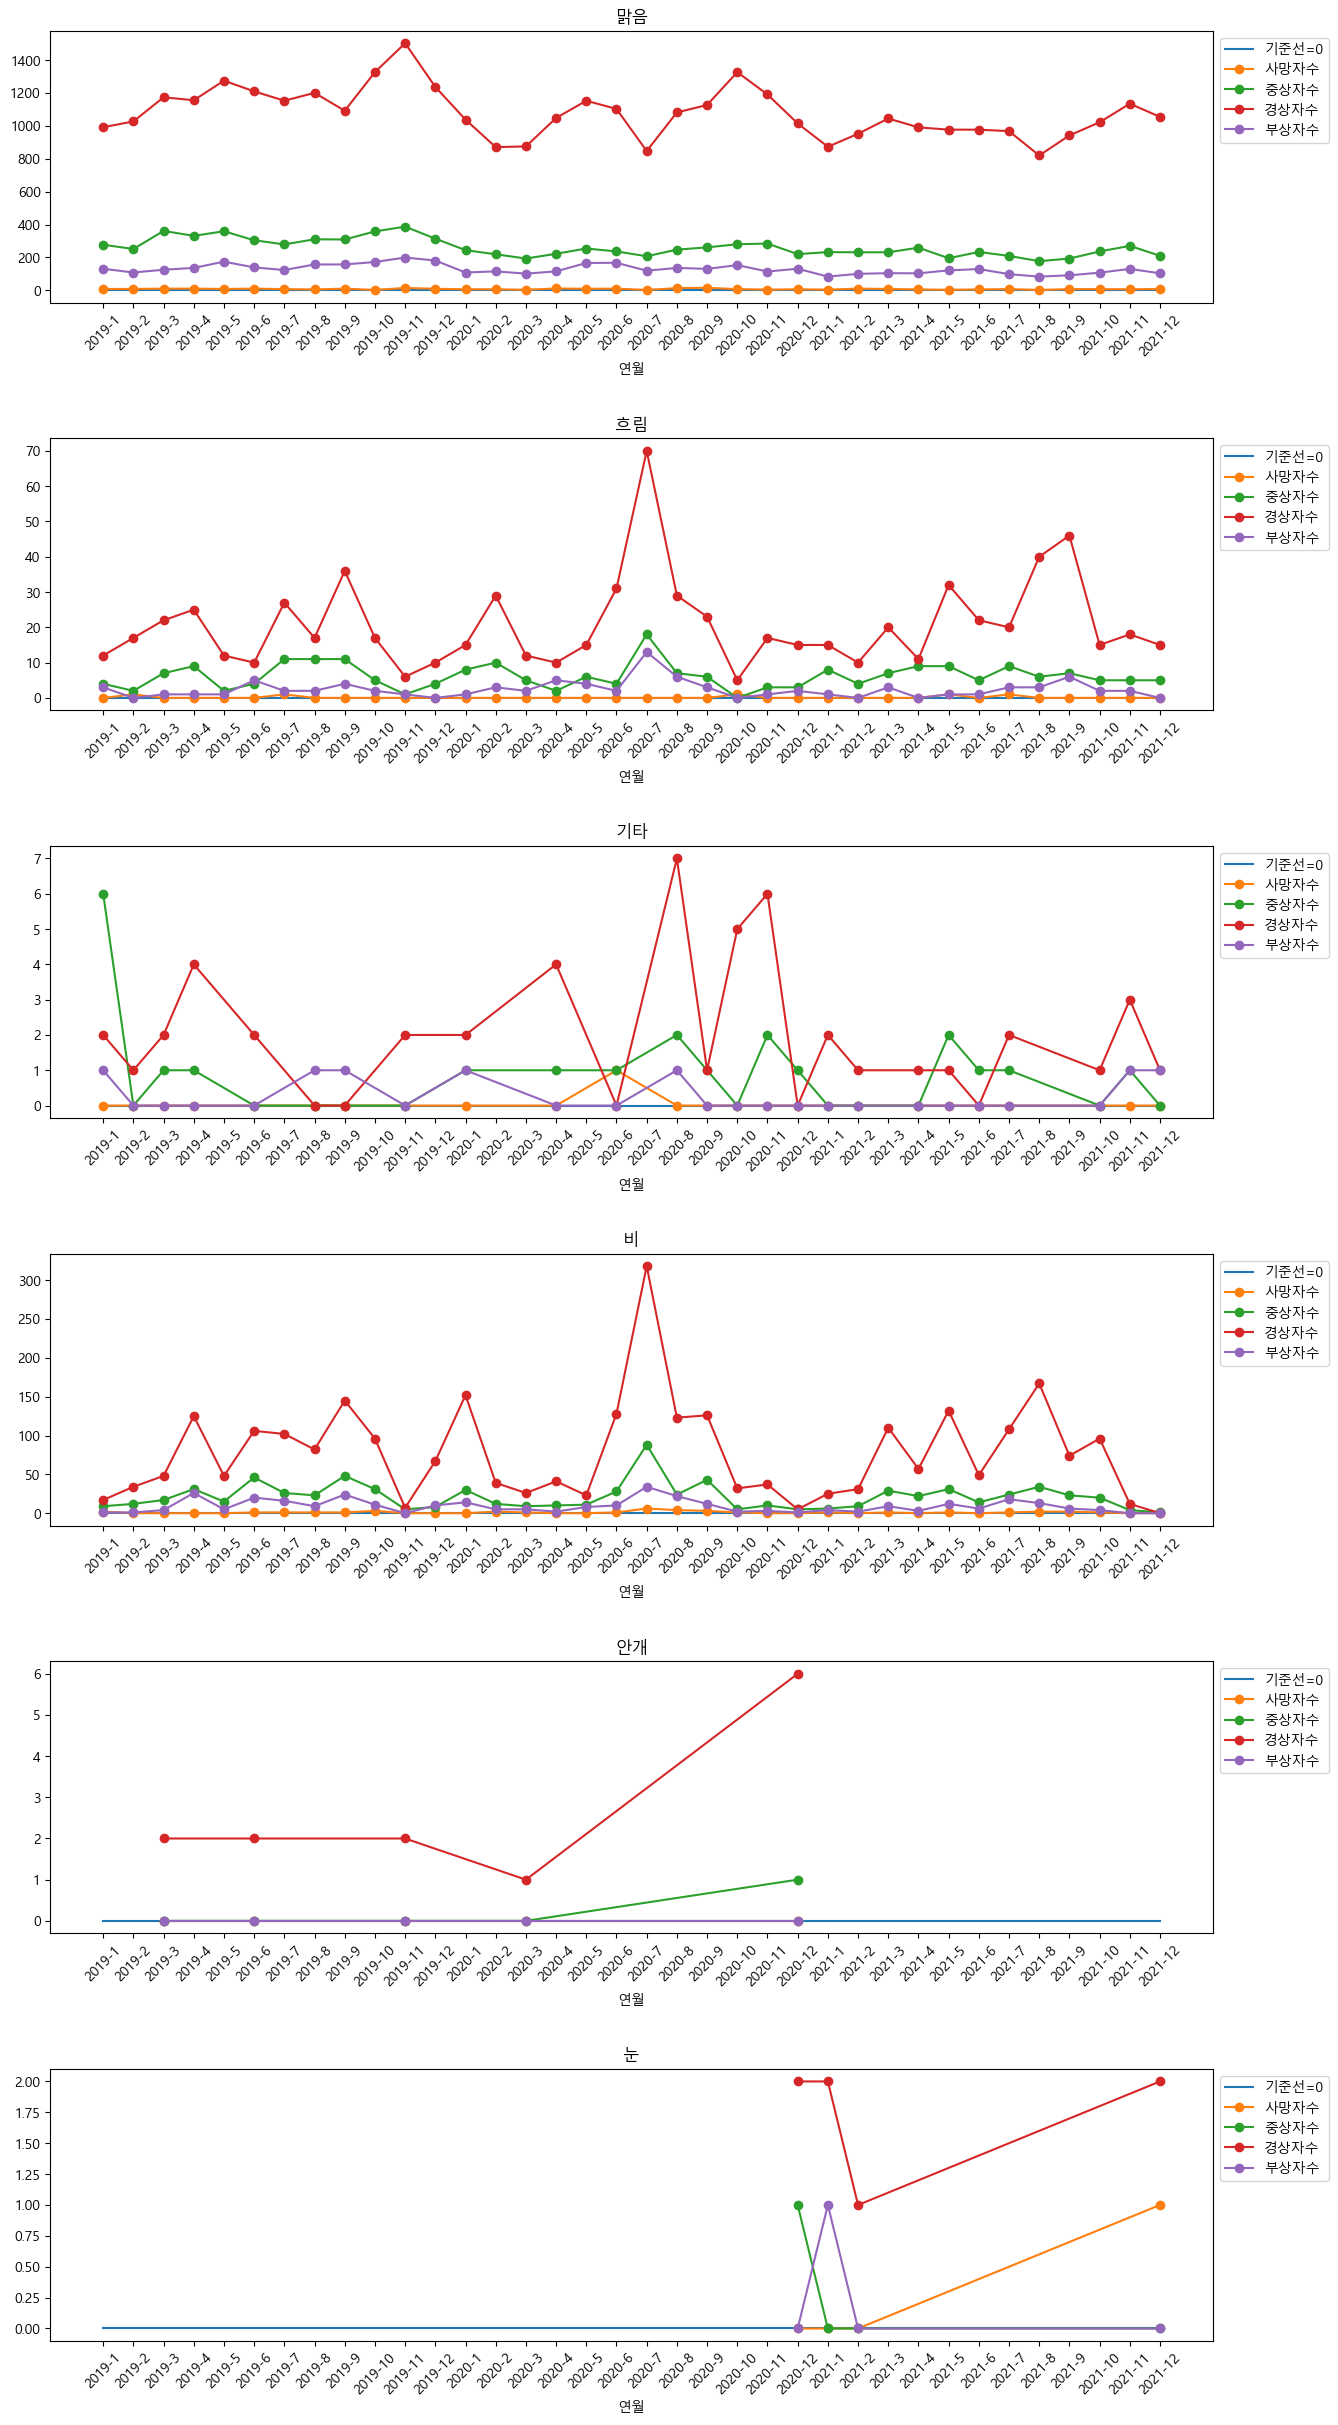

In [27]:
# 한국어 표현
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/malgun.ttf"  # 사용하고자 하는 한글 폰트 경로
font_name = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font_name)

train_df_weather_unique = train_df['기상상태'].unique()
fig=plt.figure(figsize=(15,30))

for index,j in enumerate(train_df_weather_unique):
    train_df_weather = train_df[train_df['기상상태']==j]
    train_df_weather = train_df_weather.groupby(['연','월']).agg({'사망자수': 'sum', '중상자수': 'sum','경상자수': 'sum', '부상자수': 'sum'}).reset_index()
    train_df_weather['연월'] = train_df_weather['연'].astype(str) + '-' + train_df_weather['월'].astype(str)
    ax1 = fig.add_subplot(len(train_df_weather_unique),1,index+1)
    ax1.plot((date_list),list_of_minus_ones,label='기준선=0')
    ax1.plot(train_df_weather['연월'],train_df_weather['사망자수'],label='사망자수',marker='o')
    ax1.plot(train_df_weather['연월'],train_df_weather['중상자수'],label='중상자수',marker='o')
    ax1.plot(train_df_weather['연월'],train_df_weather['경상자수'],label='경상자수',marker='o')
    ax1.plot(train_df_weather['연월'],train_df_weather['부상자수'],label='부상자수',marker='o')
    
    ax1.set_xlabel('연월')
    ax1.set_title(j)
    plt.xticks(rotation=45)
    ax1.legend(loc='upper left', bbox_to_anchor=(1, 1))  # 범례 위치 조절
plt.subplots_adjust(hspace=0.5)

2. 노면상태별 사망자수, 중상자수, 경상자수, 부상자 수 분포 (월기준)

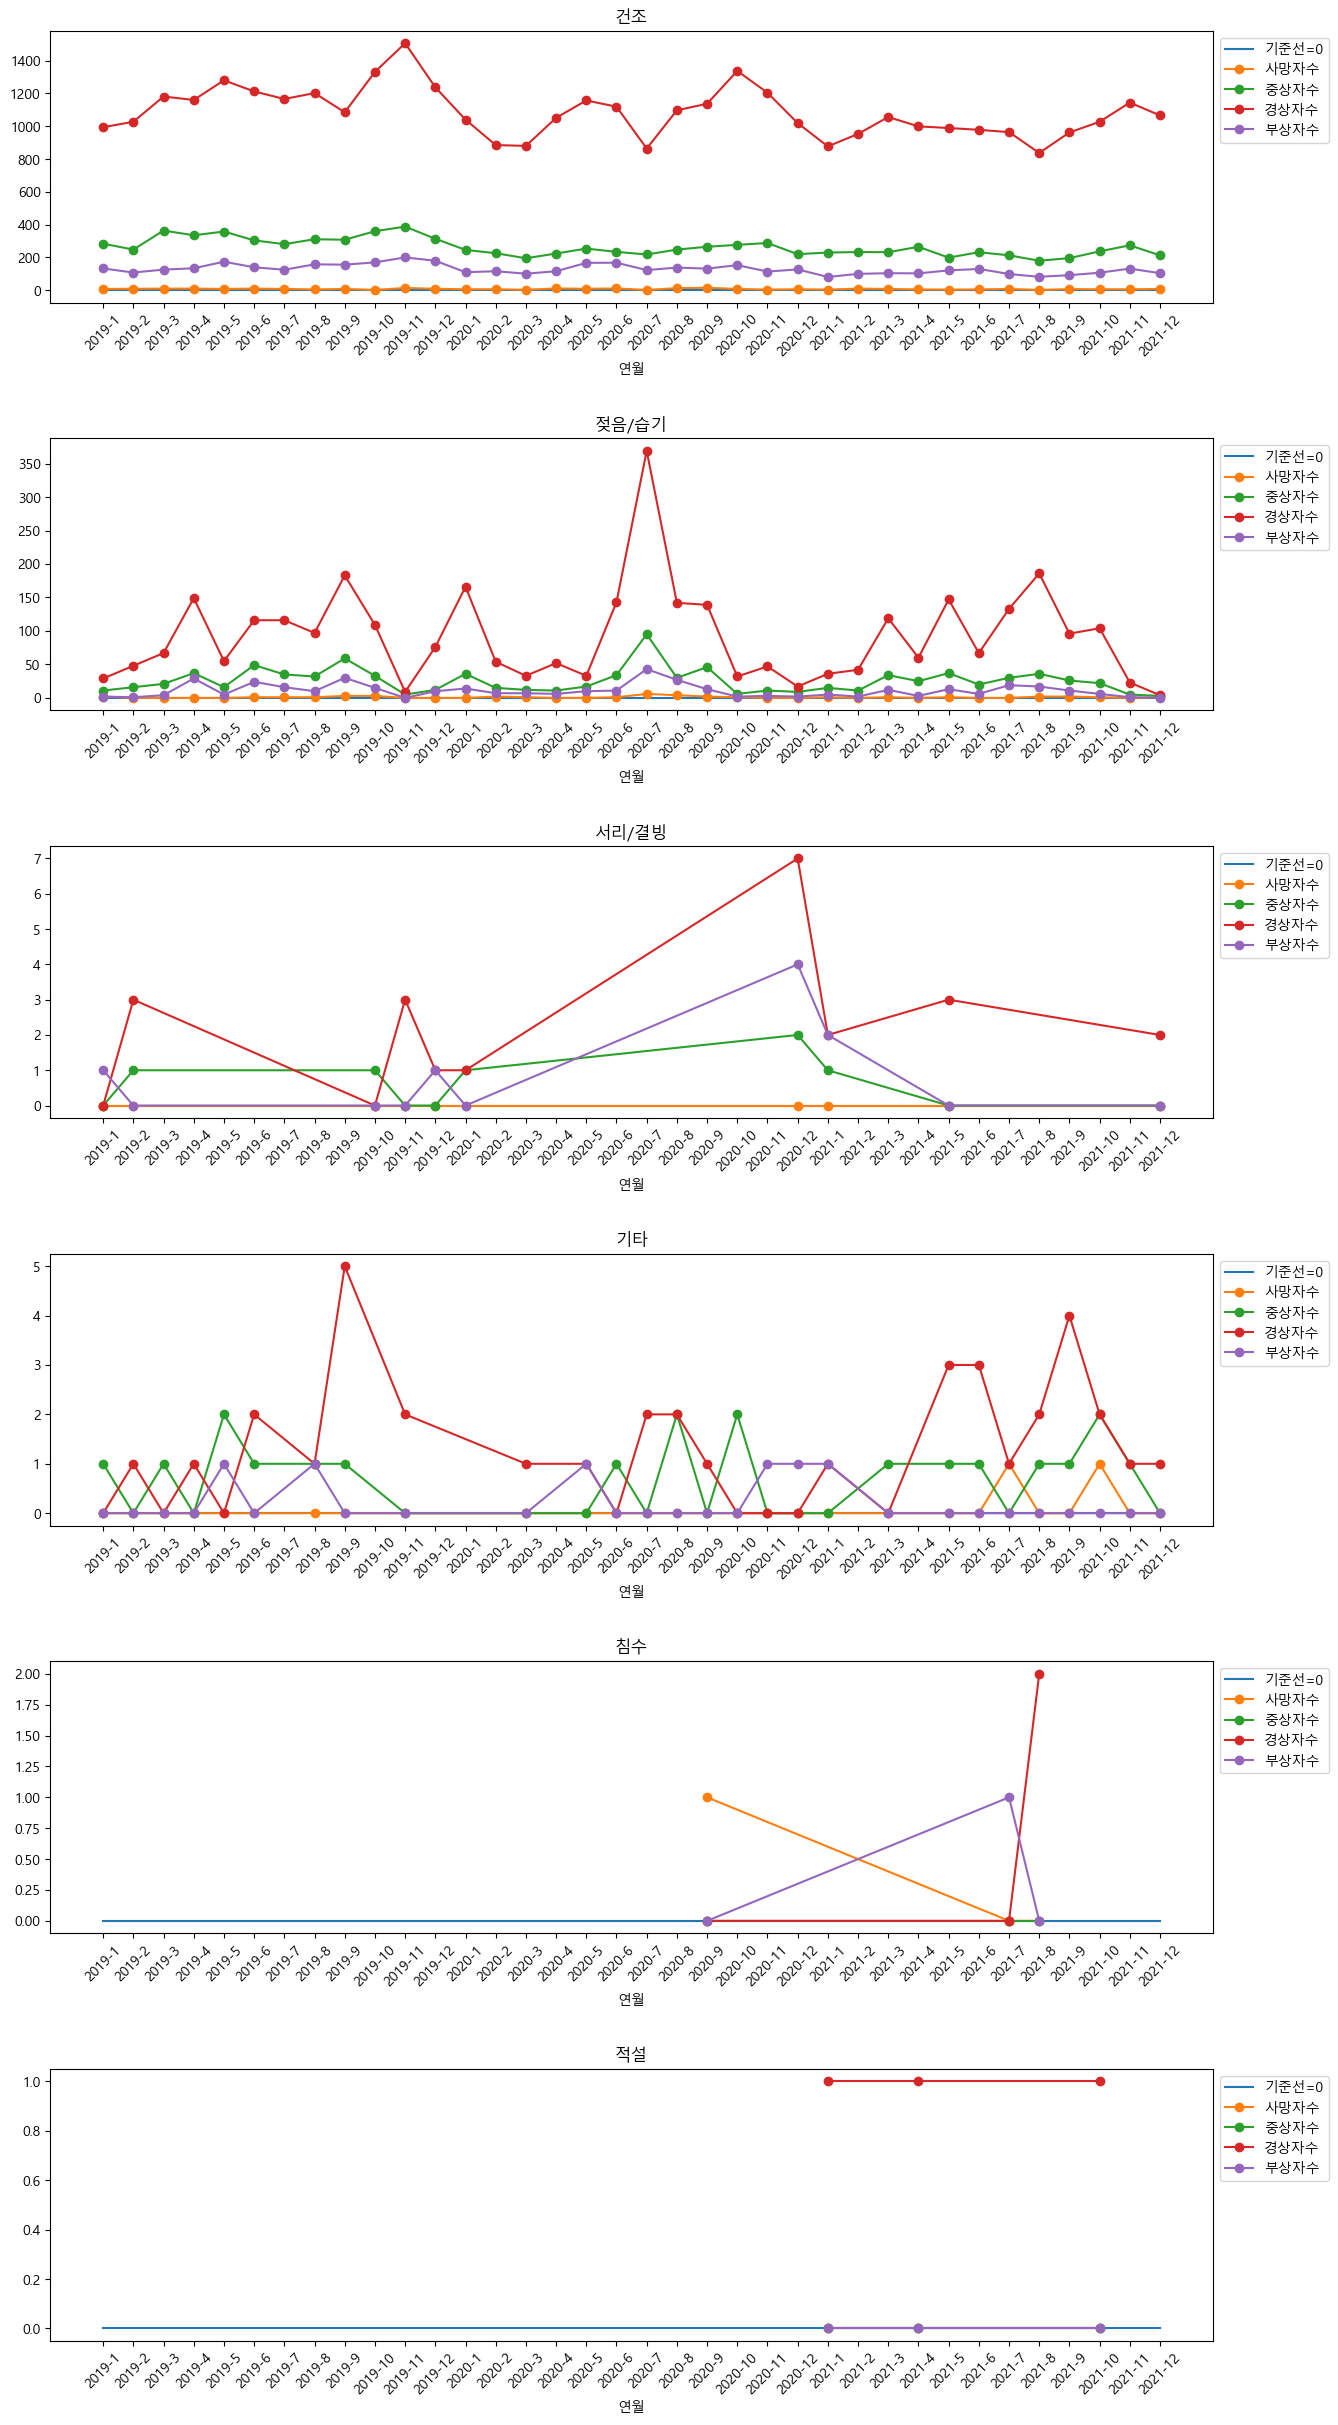

In [28]:
# 한국어 표현
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/malgun.ttf"  # 사용하고자 하는 한글 폰트 경로
font_name = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font_name)

train_df_weather_unique = train_df['노면상태'].unique()
fig=plt.figure(figsize=(15,30))

for index,j in enumerate(train_df_weather_unique):
    train_df_weather = train_df[train_df['노면상태']==j]
    train_df_weather = train_df_weather.groupby(['연','월']).agg({'사망자수': 'sum', '중상자수': 'sum','경상자수': 'sum', '부상자수': 'sum'}).reset_index()
    train_df_weather['연월'] = train_df_weather['연'].astype(str) + '-' + train_df_weather['월'].astype(str)
    ax1 = fig.add_subplot(len(train_df_weather_unique),1,index+1)
    ax1.plot((date_list),list_of_minus_ones,label='기준선=0')
    ax1.plot(train_df_weather['연월'],train_df_weather['사망자수'],label='사망자수',marker='o')
    ax1.plot(train_df_weather['연월'],train_df_weather['중상자수'],label='중상자수',marker='o')
    ax1.plot(train_df_weather['연월'],train_df_weather['경상자수'],label='경상자수',marker='o')
    ax1.plot(train_df_weather['연월'],train_df_weather['부상자수'],label='부상자수',marker='o')
    
    ax1.set_xlabel('연월')
    ax1.set_title(j)
    plt.xticks(rotation=45)
    ax1.legend(loc='upper left', bbox_to_anchor=(1, 1))  # 범례 위치 조절

plt.subplots_adjust(hspace=0.5)

3. 사고유형별 사망자수, 중상자수, 경상자수, 부상자 수 분포 (월기준)

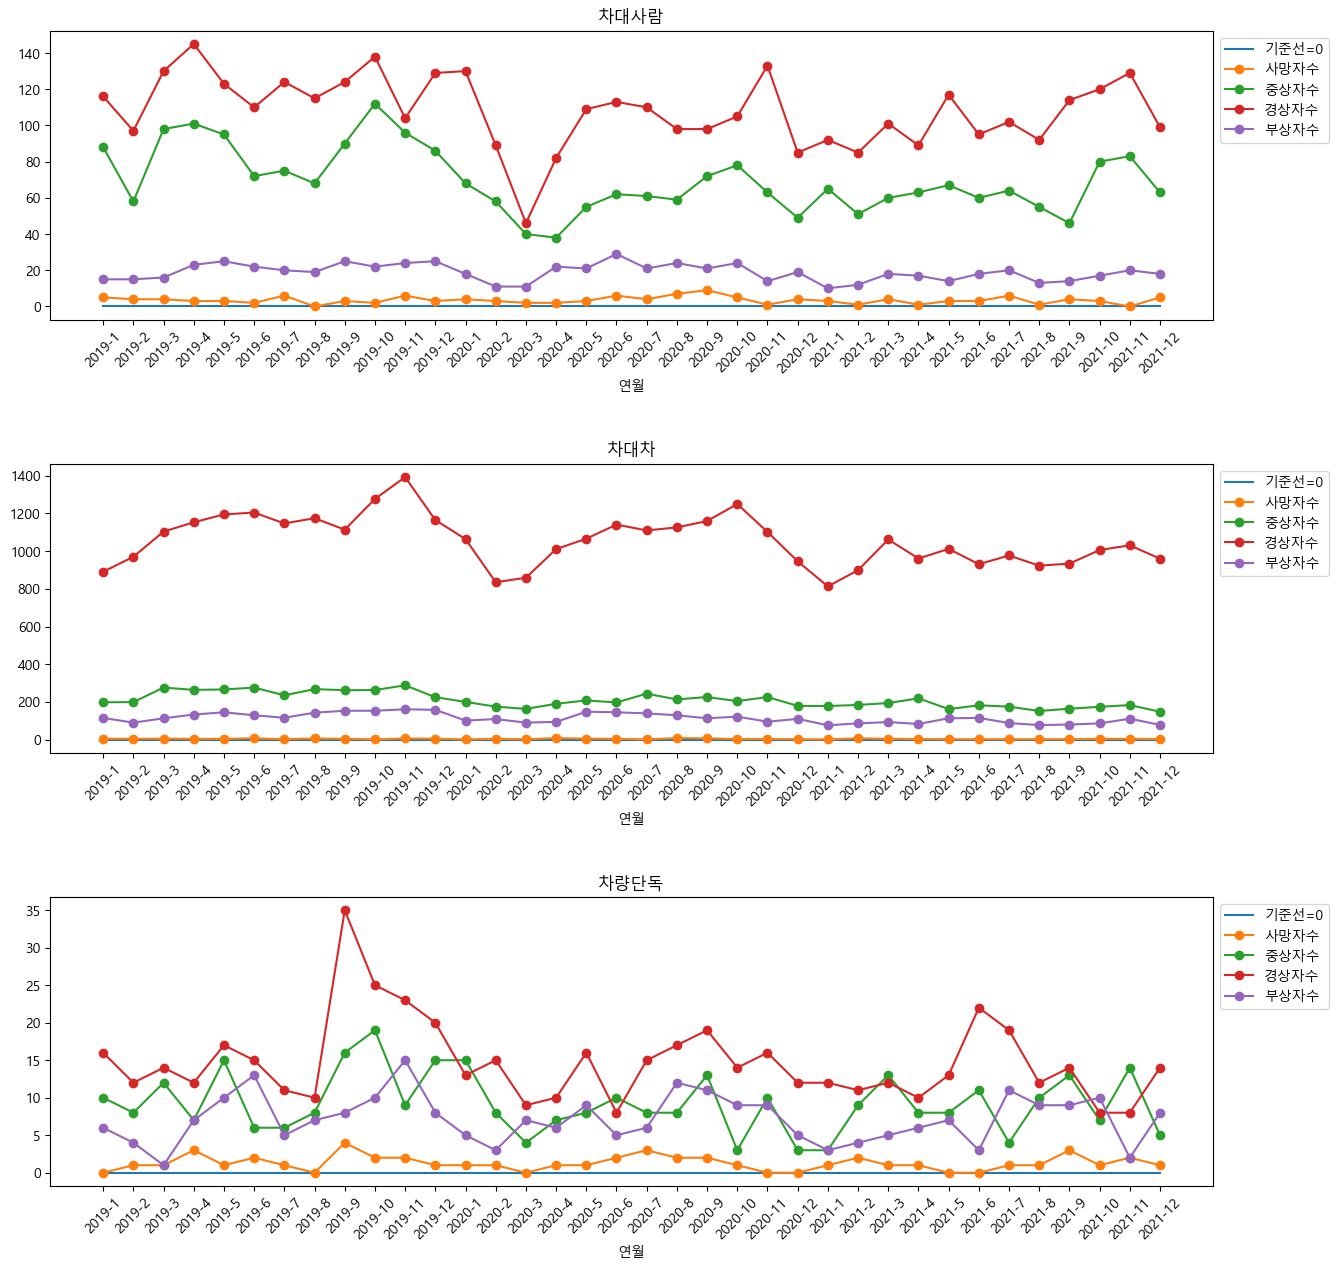

In [35]:
# 한국어 표현
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/malgun.ttf"  # 사용하고자 하는 한글 폰트 경로
font_name = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font_name)

train_df_weather_unique = train_df['사고유형'].unique()
fig=plt.figure(figsize=(15,15))

for index,j in enumerate(train_df_weather_unique):
    train_df_weather = train_df[train_df['사고유형']==j]
    train_df_weather = train_df_weather.groupby(['연','월']).agg({'사망자수': 'sum', '중상자수': 'sum','경상자수': 'sum', '부상자수': 'sum'}).reset_index()
    train_df_weather['연월'] = train_df_weather['연'].astype(str) + '-' + train_df_weather['월'].astype(str)
    ax1 = fig.add_subplot(len(train_df_weather_unique),1,index+1)
    ax1.plot((date_list),list_of_minus_ones,label='기준선=0')
    ax1.plot(train_df_weather['연월'],train_df_weather['사망자수'],label='사망자수',marker='o')
    ax1.plot(train_df_weather['연월'],train_df_weather['중상자수'],label='중상자수',marker='o')
    ax1.plot(train_df_weather['연월'],train_df_weather['경상자수'],label='경상자수',marker='o')
    ax1.plot(train_df_weather['연월'],train_df_weather['부상자수'],label='부상자수',marker='o')
    ax1.set_xlabel('연월')
    ax1.set_title(j)
    plt.xticks(rotation=45)
    ax1.legend(loc='upper left', bbox_to_anchor=(1, 1))  # 범례 위치 조절

plt.subplots_adjust(hspace=0.5)

4. 도로유형1별 사망자수, 중상자수, 경상자수, 부상자 수 분포 (월기준)

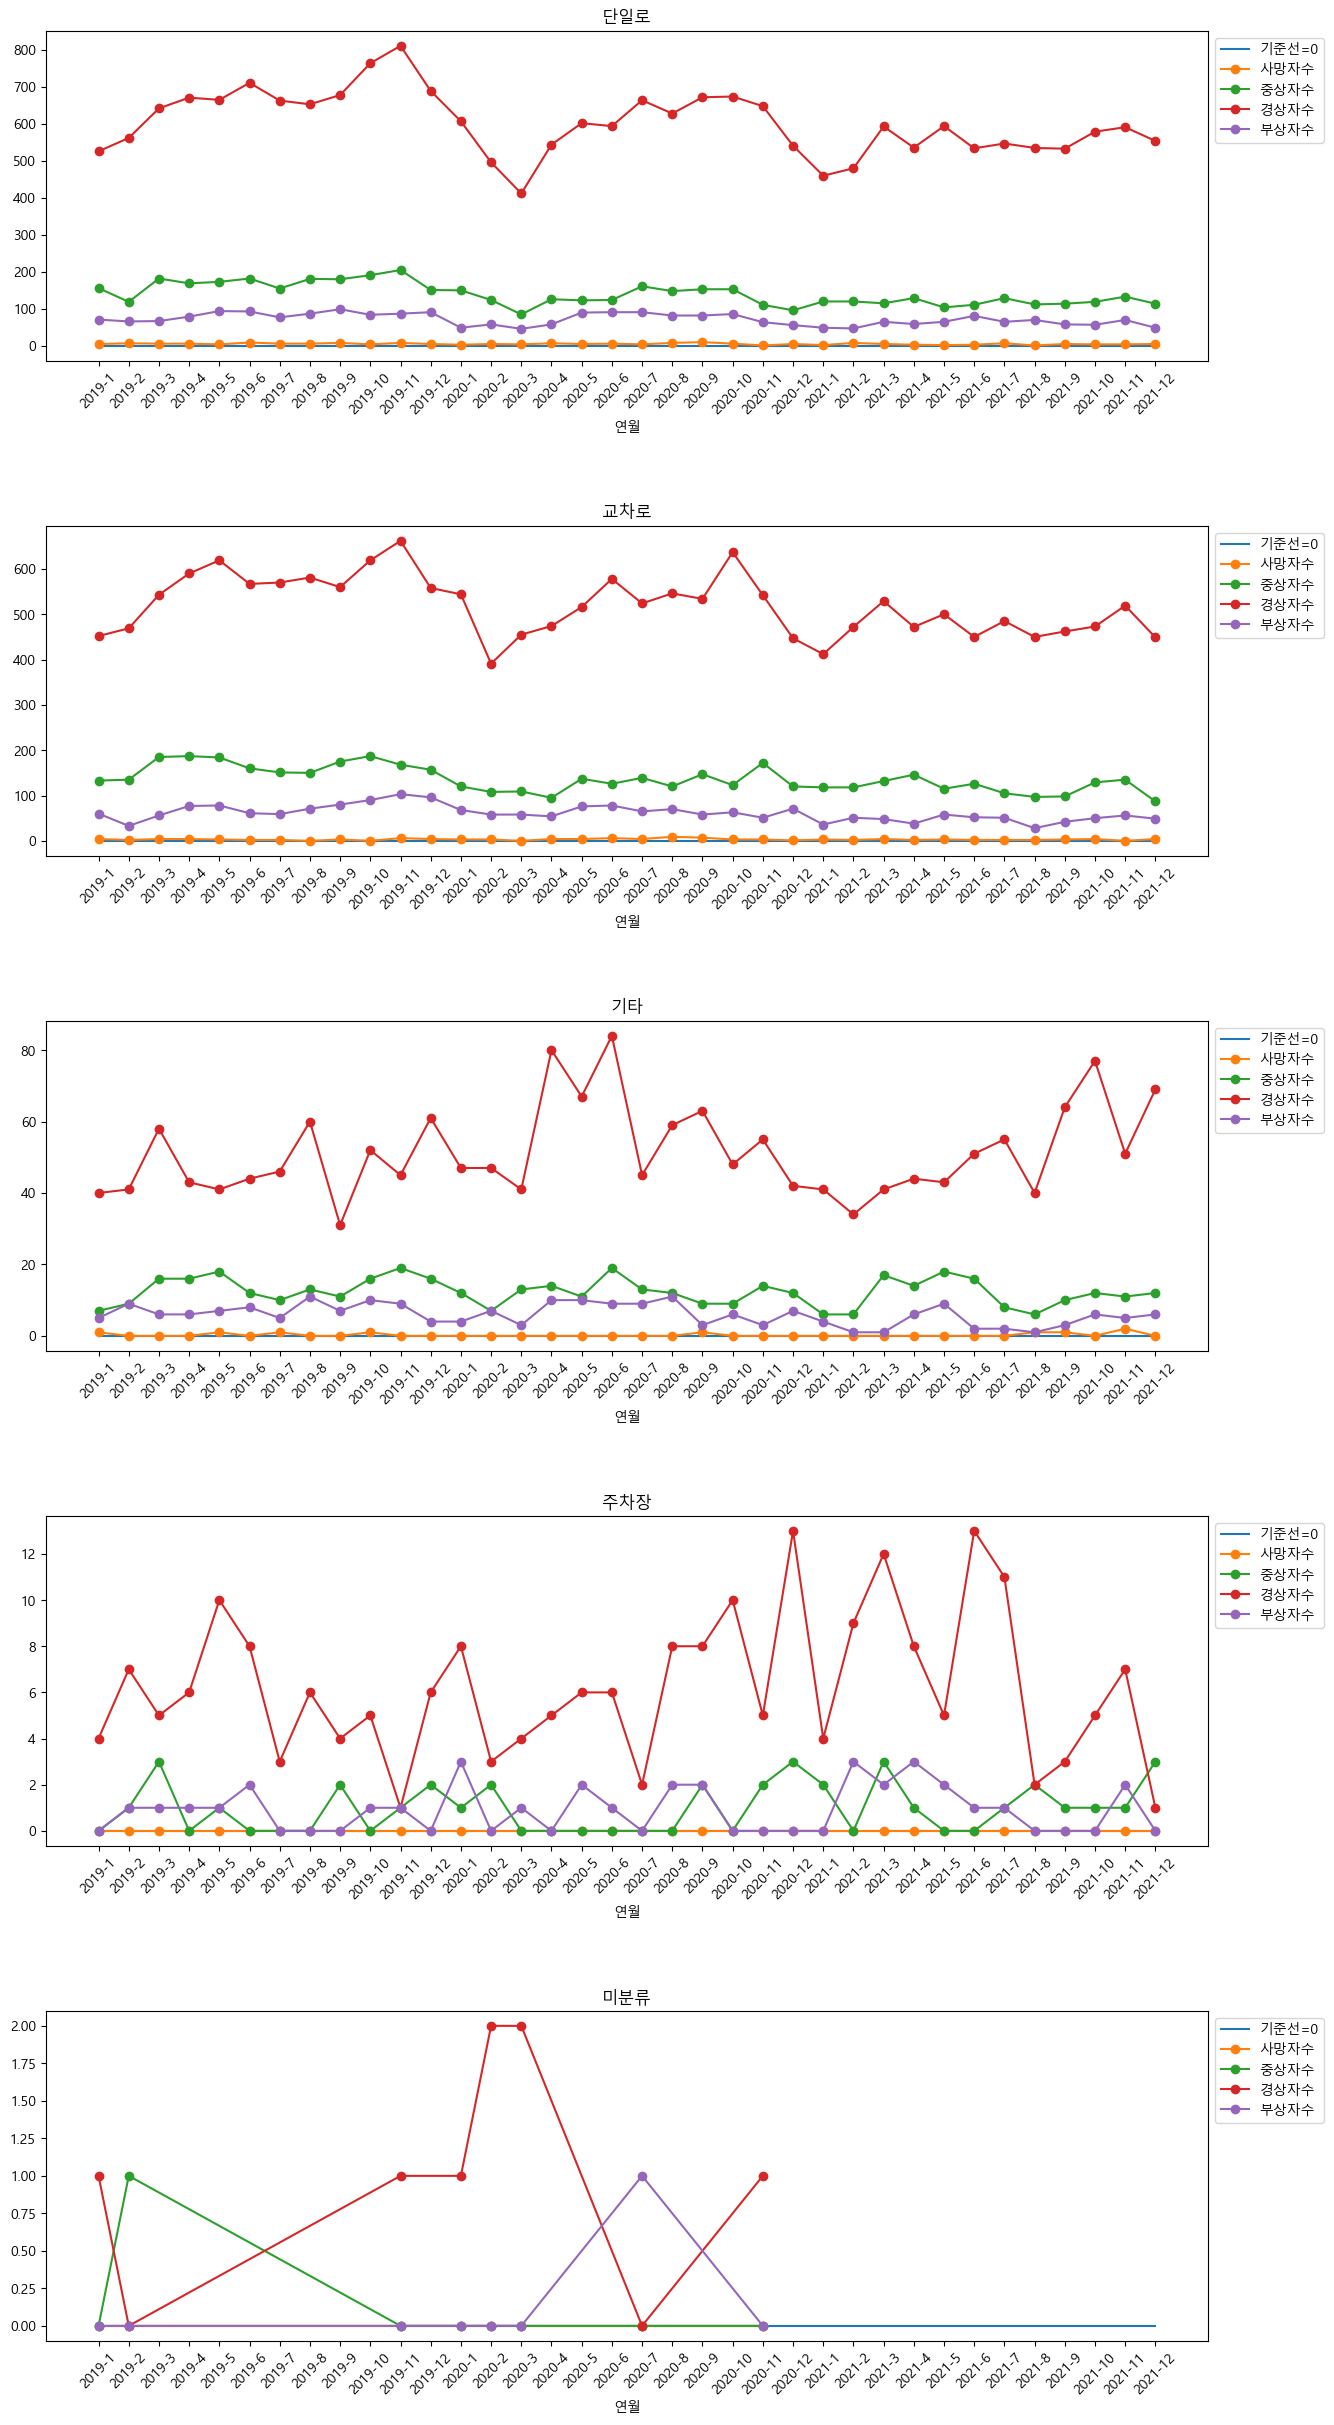

In [31]:
# 한국어 표현
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/malgun.ttf"  # 사용하고자 하는 한글 폰트 경로
font_name = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font_name)

train_df_weather_unique = train_df['도로형태1'].unique()
fig=plt.figure(figsize=(15,30))

for index,j in enumerate(train_df_weather_unique):
    train_df_weather = train_df[train_df['도로형태1']==j]
    train_df_weather = train_df_weather.groupby(['연','월']).agg({'사망자수': 'sum', '중상자수': 'sum','경상자수': 'sum', '부상자수': 'sum'}).reset_index()
    train_df_weather['연월'] = train_df_weather['연'].astype(str) + '-' + train_df_weather['월'].astype(str)
    ax1 = fig.add_subplot(len(train_df_weather_unique),1,index+1)
    ax1.plot((date_list),list_of_minus_ones,label='기준선=0')
    ax1.plot(train_df_weather['연월'],train_df_weather['사망자수'],label='사망자수',marker='o')
    ax1.plot(train_df_weather['연월'],train_df_weather['중상자수'],label='중상자수',marker='o')
    ax1.plot(train_df_weather['연월'],train_df_weather['경상자수'],label='경상자수',marker='o')
    ax1.plot(train_df_weather['연월'],train_df_weather['부상자수'],label='부상자수',marker='o')
    ax1.set_xlabel('연월')
    ax1.set_title(j)
    plt.xticks(rotation=45)
    ax1.legend(loc='upper left', bbox_to_anchor=(1, 1))  # 범례 위치 조절

plt.subplots_adjust(hspace=0.5)

5. 도로유형2별 사망자수, 중상자수, 경상자수, 부상자 수 분포 (월기준)

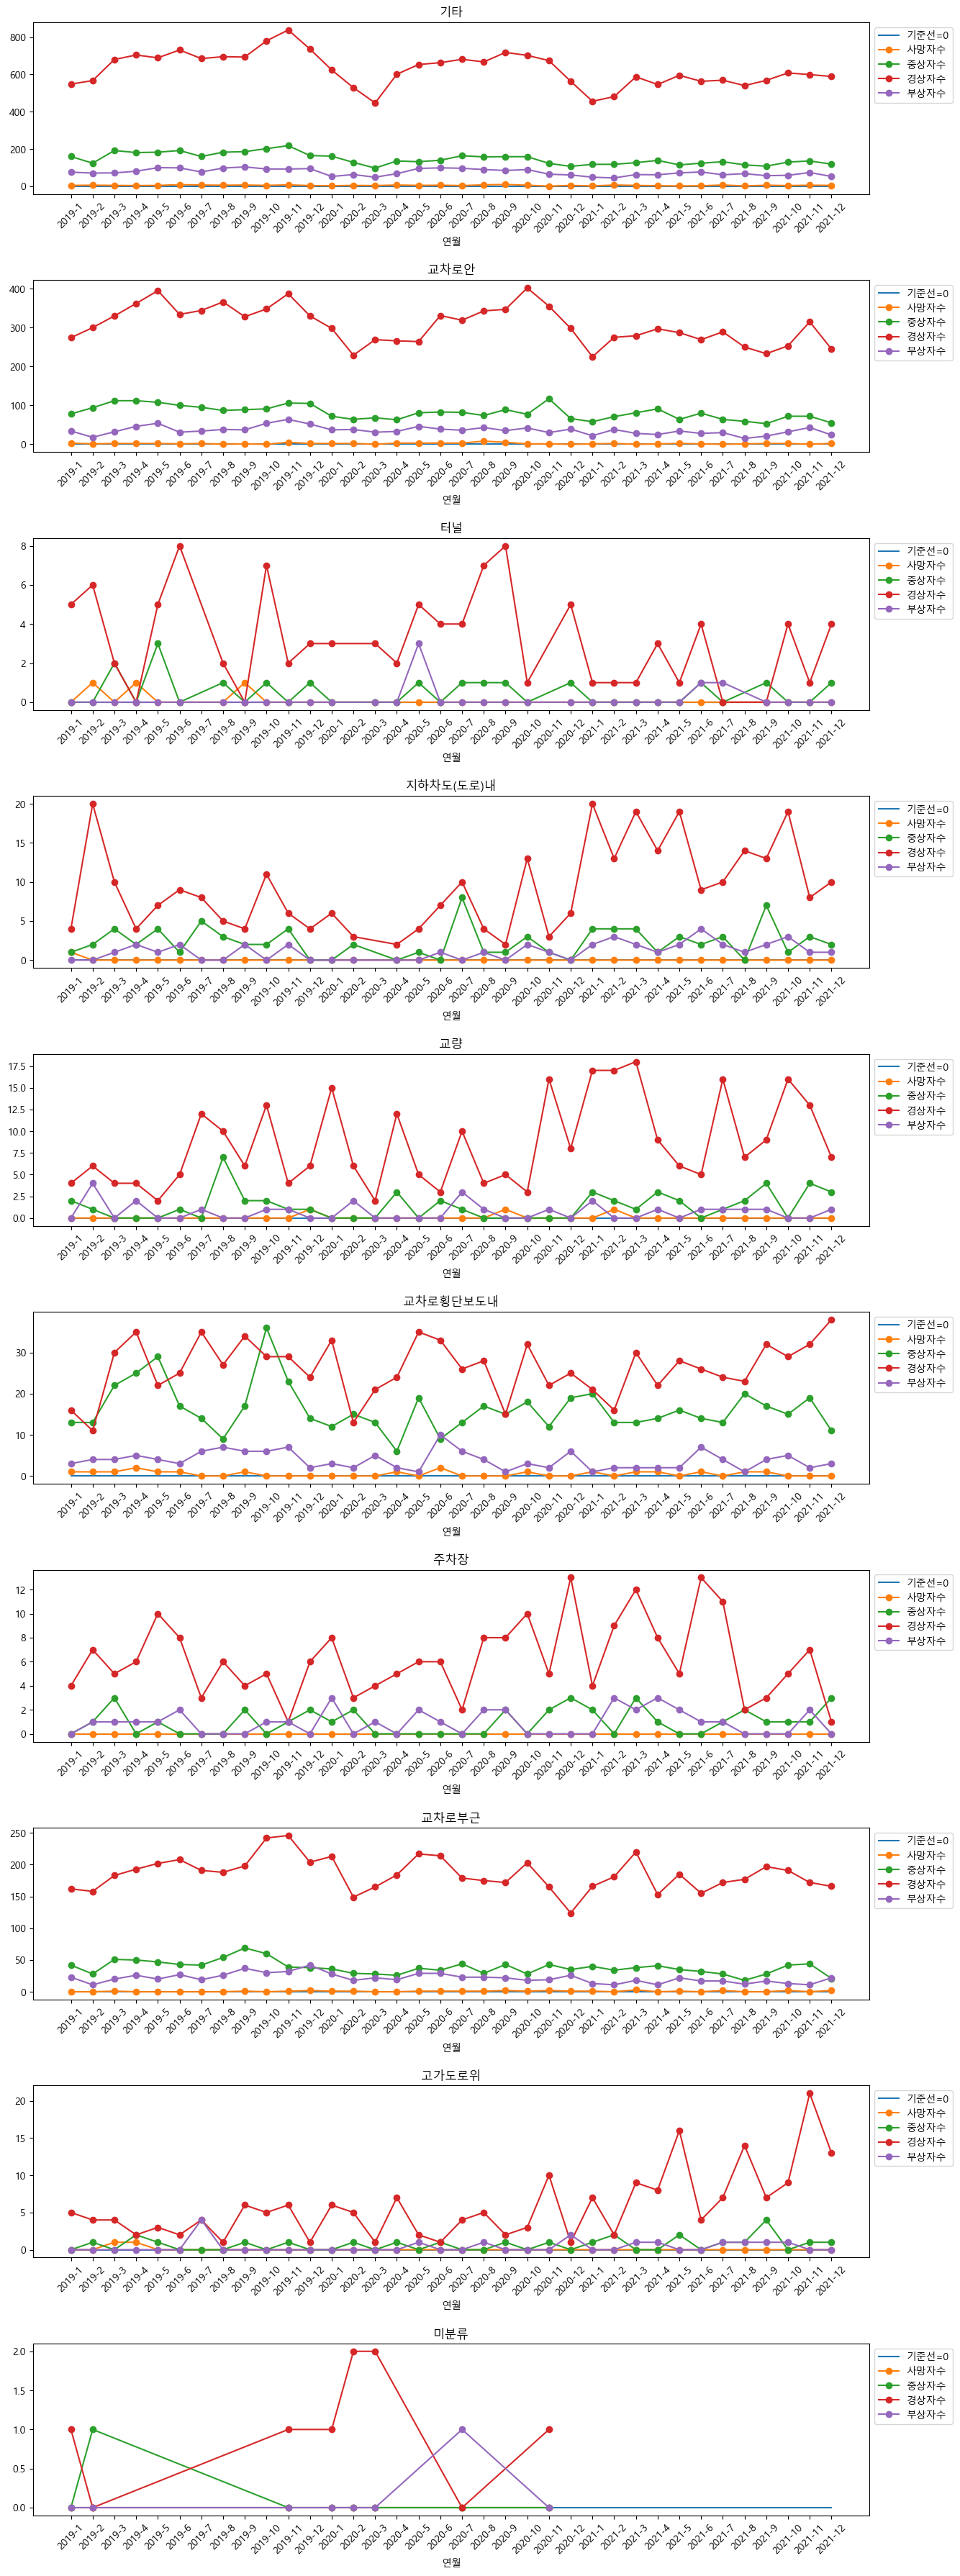

In [30]:
# 한국어 표현
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/malgun.ttf"  # 사용하고자 하는 한글 폰트 경로
font_name = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font_name)

train_df_weather_unique = train_df['도로형태2'].unique()
fig=plt.figure(figsize=(15,45))

for index,j in enumerate(train_df_weather_unique):
    train_df_weather = train_df[train_df['도로형태2']==j]
    train_df_weather = train_df_weather.groupby(['연','월']).agg({'사망자수': 'sum', '중상자수': 'sum','경상자수': 'sum', '부상자수': 'sum'}).reset_index()
    train_df_weather['연월'] = train_df_weather['연'].astype(str) + '-' + train_df_weather['월'].astype(str)
    ax1 = fig.add_subplot(len(train_df_weather_unique),1,index+1)
    ax1.plot((date_list),list_of_minus_ones,label='기준선=0')
    ax1.plot(train_df_weather['연월'],train_df_weather['사망자수'],label='사망자수',marker='o')
    ax1.plot(train_df_weather['연월'],train_df_weather['중상자수'],label='중상자수',marker='o')
    ax1.plot(train_df_weather['연월'],train_df_weather['경상자수'],label='경상자수',marker='o')
    ax1.plot(train_df_weather['연월'],train_df_weather['부상자수'],label='부상자수',marker='o')
    ax1.set_xlabel('연월')
    ax1.set_title(j)
    plt.xticks(rotation=45)
    ax1.legend(loc='upper left', bbox_to_anchor=(1, 1))  # 범례 위치 조절

plt.subplots_adjust(hspace=0.5)

6. 요일별

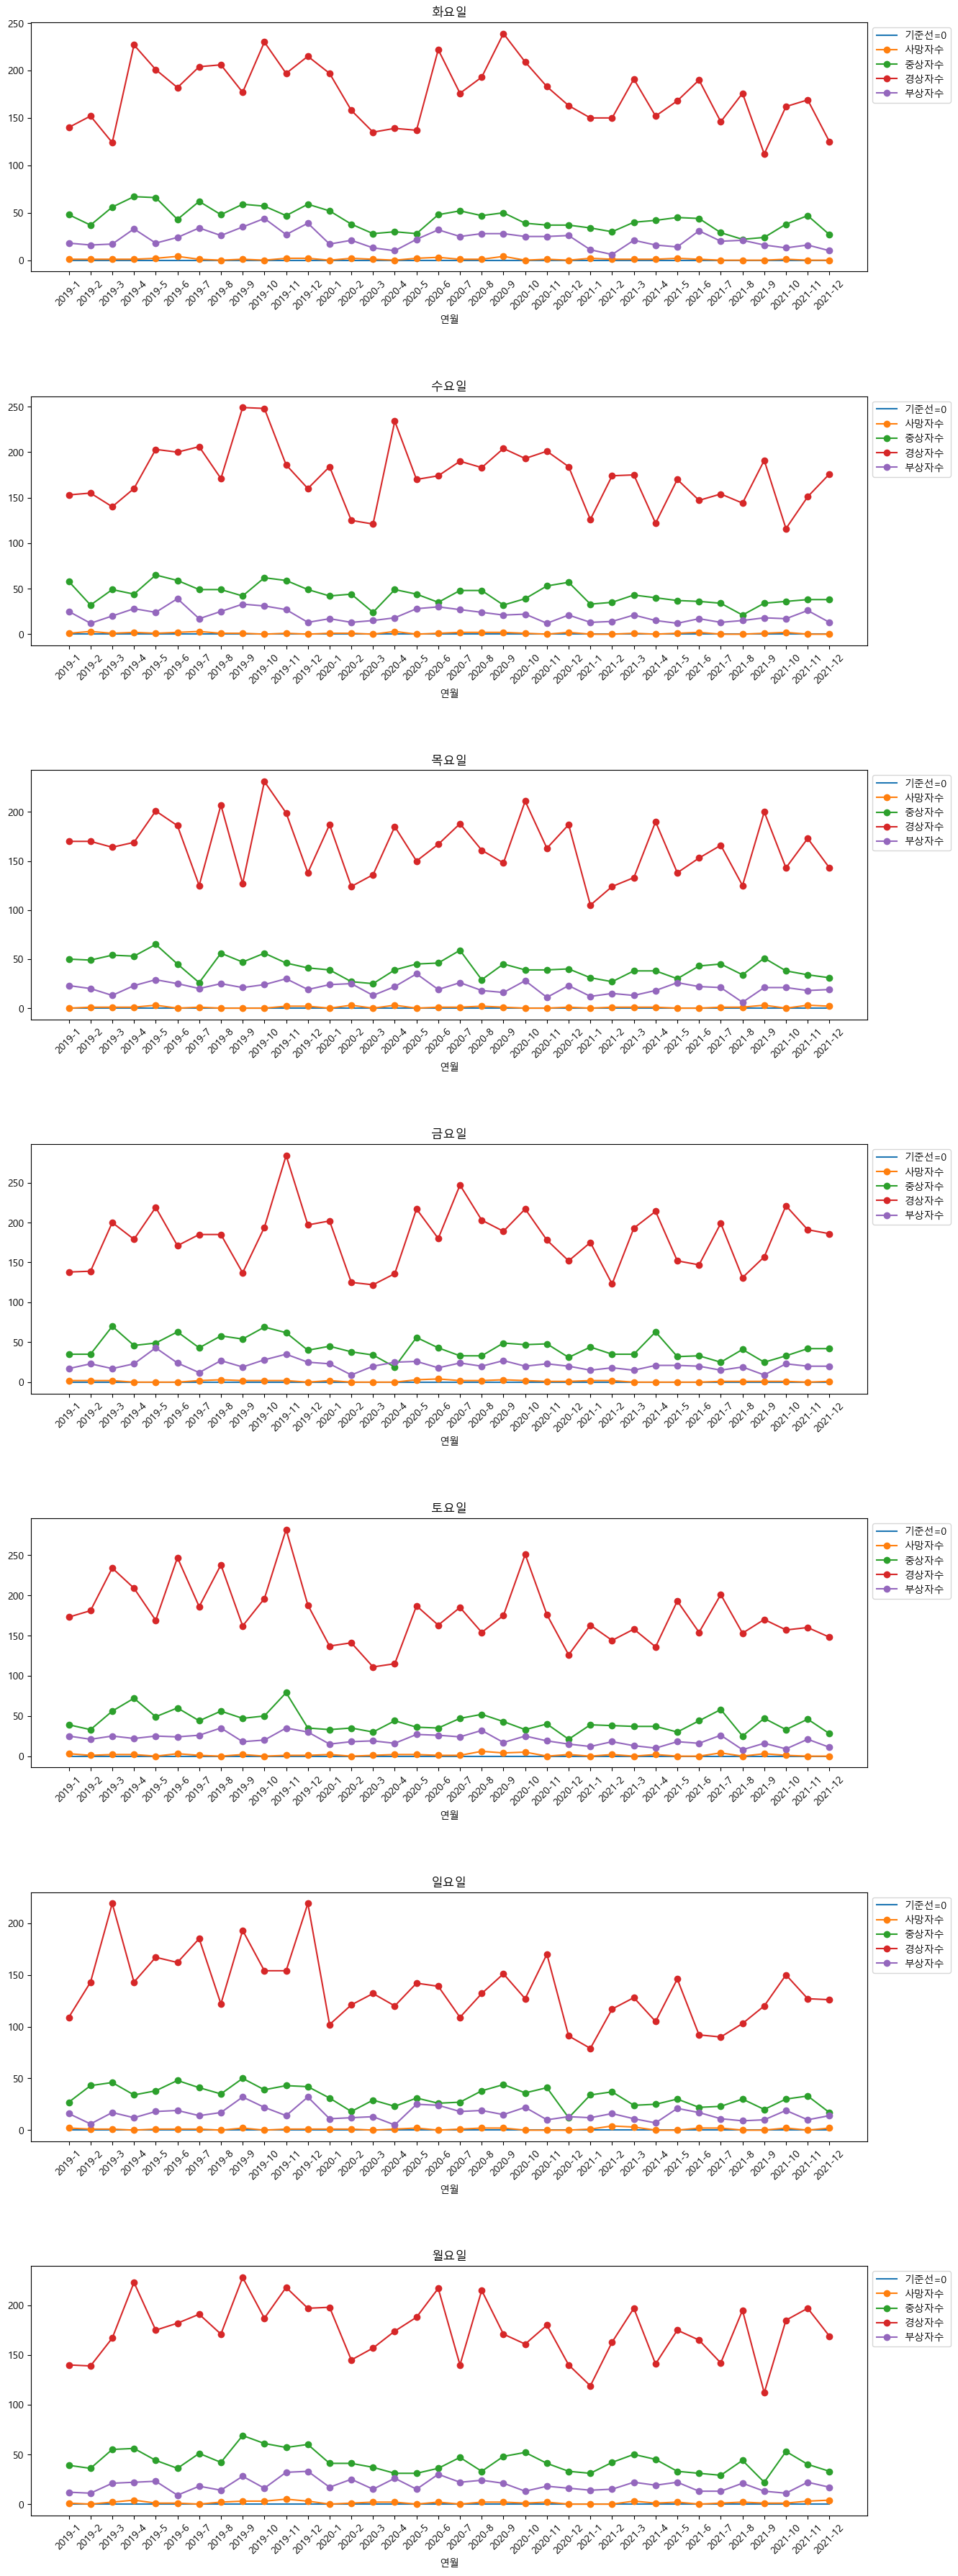

In [29]:
# 한국어 표현
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/malgun.ttf"  # 사용하고자 하는 한글 폰트 경로
font_name = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font_name)

train_df_weather_unique = train_df['요일'].unique()
fig=plt.figure(figsize=(15,45))

for index,j in enumerate(train_df_weather_unique):
    train_df_weather = train_df[train_df['요일']==j]
    train_df_weather = train_df_weather.groupby(['연','월']).agg({'사망자수': 'sum', '중상자수': 'sum','경상자수': 'sum', '부상자수': 'sum'}).reset_index()
    train_df_weather['연월'] = train_df_weather['연'].astype(str) + '-' + train_df_weather['월'].astype(str)
    ax1 = fig.add_subplot(len(train_df_weather_unique),1,index+1)
    ax1.plot((date_list),list_of_minus_ones,label='기준선=0')
    ax1.plot(train_df_weather['연월'],train_df_weather['사망자수'],label='사망자수',marker='o')
    ax1.plot(train_df_weather['연월'],train_df_weather['중상자수'],label='중상자수',marker='o')
    ax1.plot(train_df_weather['연월'],train_df_weather['경상자수'],label='경상자수',marker='o')
    ax1.plot(train_df_weather['연월'],train_df_weather['부상자수'],label='부상자수',marker='o')
    ax1.set_xlabel('연월')
    ax1.set_title(j)
    plt.xticks(rotation=45)
    ax1.legend(loc='upper left', bbox_to_anchor=(1, 1))  # 범례 위치 조절

plt.subplots_adjust(hspace=0.5)

7. 설치개수

-0.020126620065880195


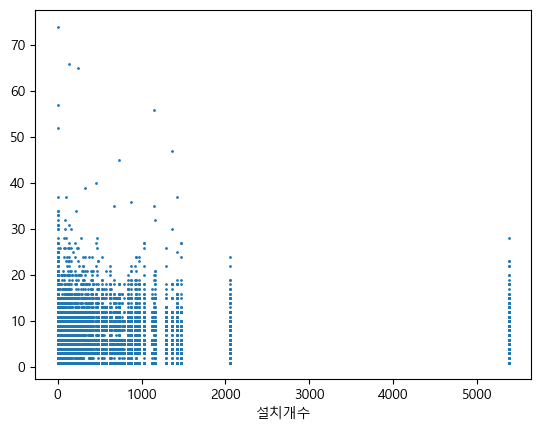

In [59]:
# 한국어 표현
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/malgun.ttf"  # 사용하고자 하는 한글 폰트 경로
font_name = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font_name)

plt.scatter(train_df['설치개수'],train_df['ECLO'],s=1)
plt.xlabel('설치개수')
print(train_df['설치개수'].corr(train_df['ECLO']))

8. 어린이 보호 구역

-0.012672094810942548


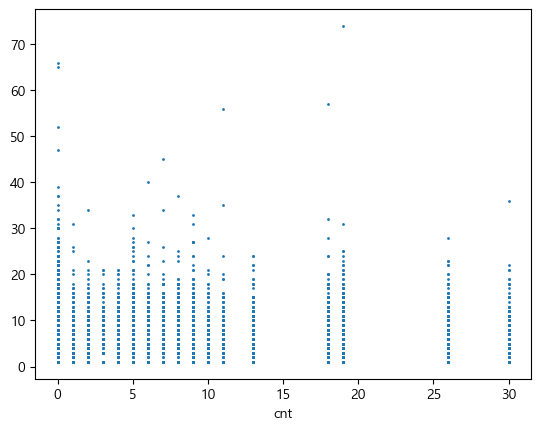

In [60]:
# 한국어 표현
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/malgun.ttf"  # 사용하고자 하는 한글 폰트 경로
font_name = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font_name)

plt.scatter(train_df['cnt'],train_df['ECLO'],s=1)
plt.xlabel('cnt')
print(train_df['cnt'].corr(train_df['ECLO']))

-0.026100604396378072


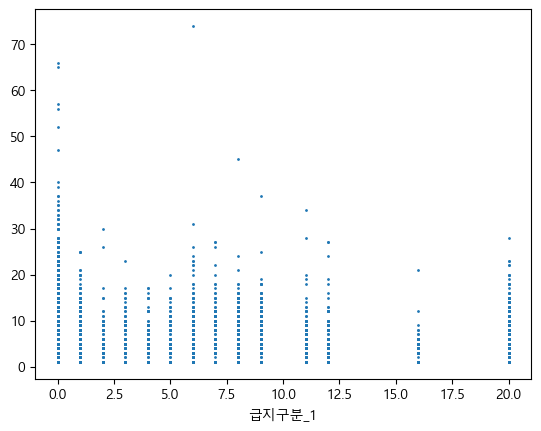

-0.013852808129671365


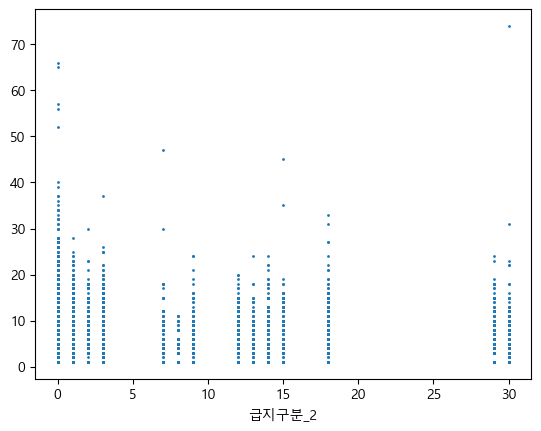

-0.0050602900726303595


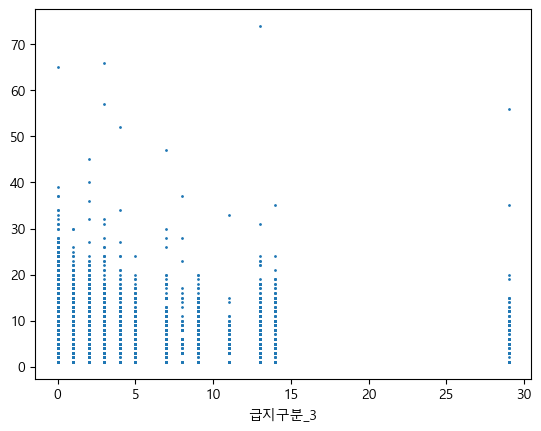

In [63]:
# 한국어 표현
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/malgun.ttf"  # 사용하고자 하는 한글 폰트 경로
font_name = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font_name)

plt.scatter(train_df['급지구분_1'],train_df['ECLO'],s=1)
plt.xlabel('급지구분_1')
print(train_df['급지구분_1'].corr(train_df['ECLO']))
plt.show()
plt.scatter(train_df['급지구분_2'],train_df['ECLO'],s=1)
plt.xlabel('급지구분_2')
print(train_df['급지구분_2'].corr(train_df['ECLO']))
plt.show()
plt.scatter(train_df['급지구분_3'],train_df['ECLO'],s=1)
plt.xlabel('급지구분_3')
print(train_df['급지구분_3'].corr(train_df['ECLO']))

In [110]:
data1 = pd.read_csv('./train.csv')
data2 = pd.read_csv('./external_open/countrywide_accident.csv')
data3 = pd.read_csv('./test.csv')
data1.columns,data3.columns

(Index(['ID', '사고일시', '요일', '기상상태', '시군구', '도로형태', '노면상태', '사고유형',
        '사고유형 - 세부분류', '법규위반', '가해운전자 차종', '가해운전자 성별', '가해운전자 연령', '가해운전자 상해정도',
        '피해운전자 차종', '피해운전자 성별', '피해운전자 연령', '피해운전자 상해정도', '사망자수', '중상자수',
        '경상자수', '부상자수', 'ECLO'],
       dtype='object'),
 Index(['ID', '사고일시', '요일', '기상상태', '시군구', '도로형태', '노면상태', '사고유형'], dtype='object'))

In [117]:
print(sorted(data1['기상상태'].unique()))
data2['노면상태'] = data2['노면상태'].astype(str)
print(sorted(data2['기상상태'].unique()))
print(sorted(data3['기상상태'].unique()))

['기타', '눈', '맑음', '비', '안개', '흐림']
['기타', '눈', '맑음', '비', '안개', '흐림']
['기타', '눈', '맑음', '비', '흐림']


"columns of train_df : Index(['ID', '사고일시', '요일', '기상상태', '시군구', '노면상태', '사고유형', '사고유형 - 세부분류',\n       '법규위반', '가해운전자 차종', '가해운전자 성별', '가해운전자 연령', '가해운전자 상해정도', '피해운전자 차종',\n       '피해운전자 성별', '피해운전자 연령', '피해운전자 상해정도', '사망자수', '중상자수', '경상자수', '부상자수',\n       'ECLO', '도로형태1', '도로형태2'],\n      dtype='object')"

,ID,기상상태,노면상태,사고유형,도로형태1,도로형태2,ECLO
0,COUNTRYWIDE_ACCIDENT_000000,맑음,건조,차대사람,교차로,교차로횡단보도내,3
1,COUNTRYWIDE_ACCIDENT_000001,맑음,건조,차대차,교차로,교차로안,3
2,COUNTRYWIDE_ACCIDENT_000002,맑음,건조,차대차,교차로,교차로안,5
3,COUNTRYWIDE_ACCIDENT_000003,맑음,건조,차대사람,기타,기타,10
4,COUNTRYWIDE_ACCIDENT_000004,맑음,건조,차대차,교차로,교차로안,7
...,...,...,...,...,...,...,...
602770,COUNTRYWIDE_ACCIDENT_602770,흐림,건조,차대차,교차로,교차로안,8
602771,COUNTRYWIDE_ACCIDENT_602771,맑음,건조,차대차,단일로,기타,6
602772,COUNTRYWIDE_ACCIDENT_602772,맑음,건조,차대차,교차로,교차로안,9
602773,COUNTRYWIDE_ACCIDENT_602773,맑음,젖음/습기,차량단독,기타,기타,1
